In [1]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import networkx as nx
#from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
import torch.nn.functional as Func
from torch.nn.functional import conv2d
from torchvision import transforms
import matplotlib.pyplot as plt
import gym
from PIL import Image
import time

In [2]:
class representation_h(nn.Module):
    def __init__(self,inp,out):
        super(representation_h, self).__init__()
        
        #residual block 1
        self.conv1 = nn.Conv2d(1, 5, kernel_size=1, stride=1)
        self.conv11 = nn.Conv2d(6, 6, kernel_size=2, stride=2)
        self.fc1 = nn.Linear(inp, inp)
        
        self.fc_main1 = nn.Linear(inp,out)
        
    def forward(self, board):
        
        act = nn.Sigmoid()
        act1 = nn.ReLU()
        
        x1 = torch.FloatTensor(board)
        x1_temp = act(self.conv1(x1))
        x1 = torch.cat((x1_temp,x1),1)
        x1 = act(self.conv11(x1))
        x1 = x1.flatten()
        x1 = self.fc1(x1)
        
        main = act1(self.fc_main1(x1))
        
        return main

In [3]:
class prediction_f(nn.Module):
    def __init__(self,f_inp,f_out1,f_out2):
        super(prediction_f, self).__init__()
        
        self.fc1 = nn.Linear(f_inp, 50)
        
        self.fc2 = nn.Linear(50, f_out1)
        
        self.fc3 = nn.Linear(50, f_out2)
        
    def forward(self, state_rep):
        
        act = nn.Sigmoid()
        act1 = nn.ReLU()
        act2 = nn.Softmax(dim=0)
        
        x = act(self.fc1(state_rep))
        
        policy = act(self.fc2(x))
        
        v_value = act1(self.fc3(x))
    
        return policy,v_value

In [4]:
class dynamic_g(nn.Module):
    def __init__(self,inp1,inp2,out1,out2):
        super(dynamic_g, self).__init__()
        
        self.fc1 = nn.Linear(inp1+inp2, 50)
        
        self.fc2 = nn.Linear(50, out1)
        
        self.fc3 = nn.Linear(50, out2)

    def forward(self, state_rep, action):
        
        act = nn.Sigmoid()
        act1 = nn.ReLU()
        
        state_rep = state_rep.flatten()
        action = action.flatten()
        x = torch.cat((state_rep,action),0)
        
        x = act(self.fc1(x))
        
        pred_state_rep = act(self.fc2(x))
        
        pred_reward = act1(self.fc3(x))
    
        return pred_state_rep,pred_reward

In [5]:
class player:
    def __init__(self):
        self.Graph = nx.DiGraph()
        
        self.max_node_num = 0
    
    def build_tree(self,H,F,G,H_board,depth,f_out1):
        
        #Get available actions
        #add edges and nodes
        
        root_state = H.forward(H_board)
        policy,v_value = F.forward(root_state)
        
        node = 0
        self.Graph.add_node(node,state=root_state,r = 0,policy = policy, v = v_value,N=1)
        
        turn = 1
        
        self.recurse_tree(H,F,G,root_state,node,depth,turn,f_out1)
        
    def recurse_tree(self,H,F,G,root_state,node,depth,turn,f_out1):
        depth += -1  
        
        if(turn == 1):
            turn = -1
        elif(turn == -1):
            turn = 1
        
        if(depth==0):
            return    
        
        for i in range(2):
            temp_node = node
            #Get policy and  v_value
            policy,v_value = F.forward(root_state)
            
            #interpret action from F
            index = random.randint(0,len(policy)-1)
            a_t = index_2_action(index,f_out1)
            a_t = torch.FloatTensor(a_t)

            #get new_state representation and predicted reward
            new_state_rep, pred_reward = G.forward(root_state,a_t)      
            
            #check if action from state exists
            prev_bool = False
            temp_edge = []
            for edge in self.Graph.out_edges(temp_node):
                a = np.array(self.Graph.edges[edge]['action'])
                b = np.array(index)
                
                if(np.array_equal(a,b)):
                    prev_bool = True
                    temp_edge = edge
                    break     
                    
            #if edge doesn't exist, add node and edge to graph
            if(not prev_bool):
                self.Graph.add_node(self.max_node_num+1,N=1,state=new_state_rep,r=pred_reward,policy = policy, v = v_value)
                self.Graph.add_edge(temp_node,self.max_node_num+1,action=index)  
                self.max_node_num+=1
                temp_node = self.max_node_num
            else:
                temp_node = temp_edge[1]
                self.Graph.nodes[temp_node]['N']+=1
            
            #go to node
            self.recurse_tree(H,F,G,new_state_rep,temp_node,depth,turn,f_out1)
        return 0
        

In [6]:
def Selection(Graph,node):
    action = []
    
    stat_list = []
    
    #get policy from THIS node
    edge_a = Graph.out_edges(node) 
    
    #if leaf node, return action with highest v value
    if(len(edge_a)==0):
        act_list = nx.get_node_attributes(Graph,'policy')[node]
        act_list = [[act_list[i],i] for i in range(len(act_list))]
        act_list.sort(reverse=True)
        #print("final q action sorted: \n {} \n".format(act_list))
        return act_list[0][1]
    
    for edge in edge_a:
        index = np.array(Graph.edges[edge]['action'])
        #print("node {} to {} with index: {}".format(node,edge[1],index))
    
        # get P
        next_P = nx.get_node_attributes(Graph,'policy')[node][index]
        
        #get next node
        next_node = edge[1]
    
        #get state_rep of next node
        #next_state_rep = nx.get_node_attributes(Graph,'state')[next_node]
    
        #get Q value given state
        next_Q = nx.get_node_attributes(Graph,'v')[next_node]
        
        #get visit count of next node
        next_N = nx.get_node_attributes(Graph,'N')[next_node]

        #append to stat list
        stat_list.append([next_Q,next_P,next_N,index])
    
    #choose max action
    action = max_action(stat_list)
    
    
    return action

In [7]:
def max_action(stat_list):
    
    #print(stat_list[0][0])
    #stat_list = stat_list[0]
    
    c1 = 1.25
    c2 = 19652
    
    #get sum of N counts
    N_b = 0
    for stat in stat_list:
        N_b += stat[2] 
    N_b = math.sqrt(N_b)
    #print("N_b: {}".format(N_b))
    
    #get index to policy from actions taken in the edges
    action_q_list = []
    temp = []
    for stat in stat_list:
        #print("{} + {} * {} * {}".format(stat[0],stat[1],(N_b/(1+stat[2])),(c1 + math.log( (N_b + c2 + 1)/c2 ,10))))
        action_q = stat[0] + stat[1]*(N_b/(1+stat[2]))*(c1 + math.log( (N_b + c2 + 1)/c2 ,10))
        action_q_list.append([action_q,stat[3]])
        temp.append(stat)
        
    index = 0
    action = 0

    #print(action_q_list)
    
    action_q_list.sort(reverse=True)

    #print(action_q_list)

    return action_q_list[0][1]

In [8]:
#Selection(ship.Graph,0)

In [9]:
def index_2_action(index,f_out1):
    a_t = np.zeros(f_out1)
    a_t[index] = 1
    return a_t

In [10]:
def get_z(reward_list,gamma):
    z_list = []
    
    count = 0
    for reward in reward_list:
        z_list.append(reward*(gamma**count))
    
    return z_list

In [11]:
def norm_q(Graph):
    
    
    return 0

In [12]:
def get_trajectory(Graph,node,action_list,value_list,policy_list,reward_list,f_out1):
    #get root node
    
    #get action & append to action list
    index = Selection(Graph,node)
    action = index_2_action(index,f_out1)
    action = torch.FloatTensor(action)
    action_list.append(action)
    
    #get v_value and append to v_list
    value = nx.get_node_attributes(Graph,'v')[node]
    value = torch.FloatTensor(value)
    value_list.append(value)
    
    #get policy and append to policy_list
    policy = nx.get_node_attributes(Graph,'policy')[node]
    policy = torch.FloatTensor(policy)
    policy_list.append(policy)
    
    #get node out edges
    edge_list = Graph.out_edges(node)
    
    #find which node to go to next
    for edge in edge_list:
        if(Graph.edges[edge]['action'] == index):
            node = edge[1]
            #get reward and append to reward_list
            reward = nx.get_node_attributes(Graph,'r')[node]
            reward = torch.FloatTensor(reward)
            reward_list.append(reward)
    
    if(len(edge_list)==0):
        return 0
    
    return get_trajectory(Graph,node,action_list,value_list,policy_list,reward_list,f_out1)

In [13]:
def arr_2_action(array):
    temp_list = list(array.detach())
    maximum = max(temp_list)
    return temp_list.index(maximum)

## Testing NN's

In [14]:
game_name = 'MsPacman-v0'
env = gym.make(game_name)
observation = env.reset()

In [15]:
print(env.action_space.sample())

8


In [16]:
print(observation.shape)

(210, 160, 3)


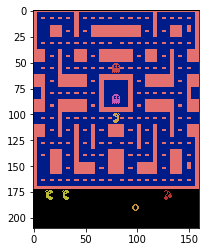

In [17]:
plt.imshow(observation)

In [18]:
def perception(state):
    sobel_x = torch.FloatTensor([[1,1,1],[1,1,1],[1,1,1]])
    
    sobel_x = sobel_x.view(1,1,3,3)
    
    grad_x = Func.conv2d(state, sobel_x,stride=2,padding=1)
    
    return grad_x

(210, 160)


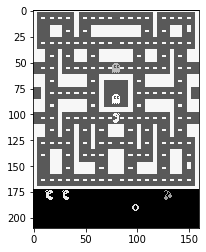

In [19]:
rgb_weights = [1,1,1]
gray_img = np.dot(observation,rgb_weights)
print(gray_img.shape)
temp_obs = plt.imshow(gray_img,cmap=plt.get_cmap("gray"))

In [20]:
rgb_weights = [1,1,1]
gray_img = np.dot(observation,rgb_weights)
temp_obs = np.reshape(gray_img,(1,1,210,160))
temp_obs1 = perception(torch.FloatTensor(temp_obs))
temp_obs2 = perception(torch.FloatTensor(temp_obs1))

In [21]:
print(temp_obs2.shape)

torch.Size([1, 1, 53, 40])


In [22]:
H_board = temp_obs2

## Define Models

In [23]:
h_inp = 3120    # size of hidden state after convolutions (made to make life easier)
h_out = 20    # hidden state, can be any number based on model

f_inp = 20    # h_out
f_out1 = 9   # number of possible actions
f_out2 = 1   # value of state

g_inp1 = 20   #h_out
g_inp2 = 9   #f_out1
g_out1 = 20   #h_out
g_out2 = 1

In [24]:
H = representation_h(h_inp,h_out)
F = prediction_f(f_inp,f_out1,f_out2)
G = dynamic_g(g_inp1,g_inp2,g_out1,g_out2)

## Data Pre-Processing

In [25]:
def data_pre_proc(observation):
    rgb_weights = [1,1,1]
    gray_img = np.dot(observation,rgb_weights)
    temp_obs = np.reshape(gray_img,(1,1,210,160))
    temp_obs1 = perception(torch.FloatTensor(temp_obs))
    temp_obs2 = perception(torch.FloatTensor(temp_obs1))  
    return temp_obs2

## Loss functions

In [26]:
f_param = list(F.parameters())
g_param = list(G.parameters())
h_param = list(H.parameters())

criterion_p = nn.MSELoss()
optimizer_p = optim.Adam(f_param+g_param+h_param, lr=0.01)

criterion_v = nn.MSELoss()
optimizer_v = optim.Adam(f_param+g_param+h_param, lr=0.01)

criterion_r = nn.MSELoss()
optimizer_r = optim.Adam(g_param+h_param, lr=0.01)

## Hyper-parameters

In [27]:
Buffer = []
loss_list = []
game_name = 'Asteroids-v0'
game_name = 'MsPacman-v0'
gamma = .99
epochs = 100
steps = 1
depth = 5

## Train

In [ ]:
for epoch in range(epochs):
    print("EPOCH {}".format(epoch))
    
    #start game
    env = gym.make(game_name)
    observation = env.reset()
    
    #get players and state
    ship = player()
 
    #collect lists
    policy_list = []
    action_list = []

    value_list = []
    z_list = []

    reward_list = []
    imm_reward_list = []

    done = 0
    for i in range(100):
        
        #data preprocessing
        H_board = data_pre_proc(observation)

        #build tree
        ship.build_tree(H,F,G,H_board,depth,f_out1)

        #Find best move
        action = get_trajectory(ship.Graph,0,action_list,value_list,policy_list,reward_list,f_out1)    
        temp_depth = depth
        for j in range(depth-1):
            #take action
            action = arr_2_action(action_list[j])
            #env.render()
            observation, reward, done, info = env.step(action)
            imm_reward_list.append(reward)
            if(done):
                temp_depth = j
                break
        
        z_list = get_z(imm_reward_list,gamma)
        
        if(done):
            break
        
        #list checking
        #print("z: {} v: {} ".format(len(z_list),len(value_list)))
        #print("im_r: {} r: {}".format(len(imm_reward_list),len(reward_list)))
        #print("policy: {} action: {}".format(len(policy_list),len(action_list)))
    
        #print(torch.FloatTensor([z_list[i]]))
        
    
    #train
    Total_loss = 0
    for i in range(temp_depth-1):
        policy_loss = criterion_p(action_list[i],policy_list[i])
        value_loss = criterion_v(torch.FloatTensor([z_list[i]]),value_list[i])
        reward_loss = criterion_r(torch.FloatTensor([imm_reward_list[i]]),reward_list[i])
        Total_loss+= policy_loss + value_loss + reward_loss
    
    optimizer_p.step()
    optimizer_v.step()
    optimizer_r.step()
    
    loss_list.append(Total_loss)   
    env.close()
    print(Total_loss)

EPOCH 0
tensor(0.9379, grad_fn=<AddBackward0>)
EPOCH 1
tensor(0.9690, grad_fn=<AddBackward0>)
EPOCH 2
tensor(0.9660, grad_fn=<AddBackward0>)
EPOCH 3
tensor(0.8982, grad_fn=<AddBackward0>)
EPOCH 4
tensor(0.9439, grad_fn=<AddBackward0>)
EPOCH 5
tensor(0.9577, grad_fn=<AddBackward0>)
EPOCH 6
tensor(0.9171, grad_fn=<AddBackward0>)
EPOCH 7
tensor(0.9261, grad_fn=<AddBackward0>)
EPOCH 8
tensor(0.9675, grad_fn=<AddBackward0>)
EPOCH 9
tensor(0.9210, grad_fn=<AddBackward0>)
EPOCH 10
tensor(0.9157, grad_fn=<AddBackward0>)
EPOCH 11
tensor(0.9316, grad_fn=<AddBackward0>)
EPOCH 12
tensor(0.8956, grad_fn=<AddBackward0>)
EPOCH 13
tensor(0.9182, grad_fn=<AddBackward0>)
EPOCH 14
tensor(0.8793, grad_fn=<AddBackward0>)
EPOCH 15
tensor(0.9147, grad_fn=<AddBackward0>)
EPOCH 16
tensor(0.9088, grad_fn=<AddBackward0>)
EPOCH 17
tensor(0.9283, grad_fn=<AddBackward0>)
EPOCH 18
tensor(0.8890, grad_fn=<AddBackward0>)
EPOCH 19
tensor(0.9176, grad_fn=<AddBackward0>)
EPOCH 20
tensor(0.9135, grad_fn=<AddBackward0>)
EP

In [ ]:
plt.plot([i for i in range(len(loss_list))],loss_list)

In [ ]:
done = 0
while(done == False):

    #data preprocessing
    H_board = data_pre_proc(observation)

    #build tree
    ship.build_tree(H,F,G,H_board,depth,f_out1)

    #Find best move
    action = get_trajectory(ship.Graph,0,action_list,value_list,policy_list,reward_list,f_out1)   
    
    env.render()
    time.sleep(.01)
    observation, reward, done, info = env.step(action)
    
    if(done):
        env.close()
        break
